# Code for Producing Figure 4

### From the paper:  
**"The Cultural Macroevolution of Arcade Video Games: Innovation, Collaboration, and Collapse"**  

**Authors:**  
Sergi Valverde, Blai Vidiella, Andrej Spiridonov, R. Alexander Bentley  

**Date:** April 24, 2025  
**Location:** Barcelona  

This notebook generates **Figure 4**, which visualizes the evolutionary trends of arcade video games, including ROM size, CPU speed, and collaboration patterns over time. It analyzes different game categories, identifies collapsing subcategories, and applies power-law fitting to assess scaling relationships in the dataset.


**Data Source**  
- The script loads data from `arcade.csv`, a dataset containing arcade game information.  
- Each row represents an arcade game with attributes such as:  
  - `main_category` (e.g., Shooter, Fighter, Maze)  
  - `sub_category` (e.g., Aerial Combat, Gun-Based)  
  - `log_rom_size` (log-transformed ROM storage size)  
  - `log_clock_speed` (log-transformed CPU clock speed)  
  - `collaboration` (e.g., bootleg vs. collaboration)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
from scipy.stats import linregress, gaussian_kde, t

# Suppress warnings
warnings.filterwarnings("ignore")

# Load data
df_prod = pd.read_csv("arcade.csv")
print(df_prod.info())

# Create dictionary mapping from category_id to (main_category, sub_category)
category_map = (
    df_prod
    .drop_duplicates(subset="category_id")[["category_id", "main_category", "sub_category"]]
    .set_index("category_id")
    .apply(tuple, axis=1)
    .to_dict()
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7822 entries, 0 to 7821
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7822 non-null   int64  
 1   year             7822 non-null   float64
 2   title            7822 non-null   object 
 3   firm             7822 non-null   object 
 4   firm_id          7822 non-null   int64  
 5   log_rom_size     7822 non-null   float64
 6   log_clock_speed  7822 non-null   float64
 7   collaboration    7822 non-null   object 
 8   main_category    7822 non-null   object 
 9   sub_category     7822 non-null   object 
 10  category_id      7822 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 672.3+ KB
None


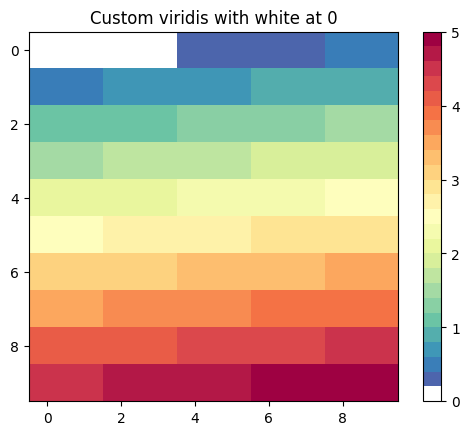

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Example data
data = np.linspace(0, 5, 100).reshape(10, 10)

# Define data range
vmin, vmax = 0, 5
n_colors = 25

# Get the base colormap (viridis in this case)
base_cmap = plt.cm.Spectral_r

# Convert to a ListedColormap (an editable array of colors)
colors = base_cmap(np.linspace(0, 1, n_colors))
custom_cmap = ListedColormap(colors)

# Find the index corresponding to 0 in the data range
zero_index = int((0 - vmin) / (vmax - vmin) * (n_colors - 1))

# Replace the color at 0 with white
colors[zero_index] = [1, 1, 1, 1]  # RGBA for white
custom_cmap = ListedColormap(colors)

# Plot using the modified colormap
plt.imshow(data, cmap=custom_cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Custom viridis with white at 0")
plt.show()

Collapsing subcategories in Maze:
33 ('Maze', 'Move and Sort')
34 ('Maze', 'Outline')
38 ('Maze', 'Cross')
6 ('Maze', 'Shooter Small')
10 ('Maze', 'Collect')
20 ('Maze', 'Driving')
Maze (Clone-dominant) [33, 34, 38, 6, 10, 20]
------
Processed 444 rows (5.68%)
Fitted power-law: y = 0.01 * x^2.50
Exponent b: 2.5032 ± 0.3306 (95% CI)
R²: 0.3519
Platform (All) [18, 18, 18, 18, 18, 32, 18, 18, 18, 18, 18, 18, 40, 40, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 40, 18, 18, 18, 18, 18, 40, 40, 40, 40, 40, 40, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 57, 57, 18, 18, 18, 18, 18, 18, 18, 57, 57, 18, 40, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 57, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 60, 60, 18, 18, 18, 40, 18, 18, 40, 18, 18, 18, 18, 40, 40, 57, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,

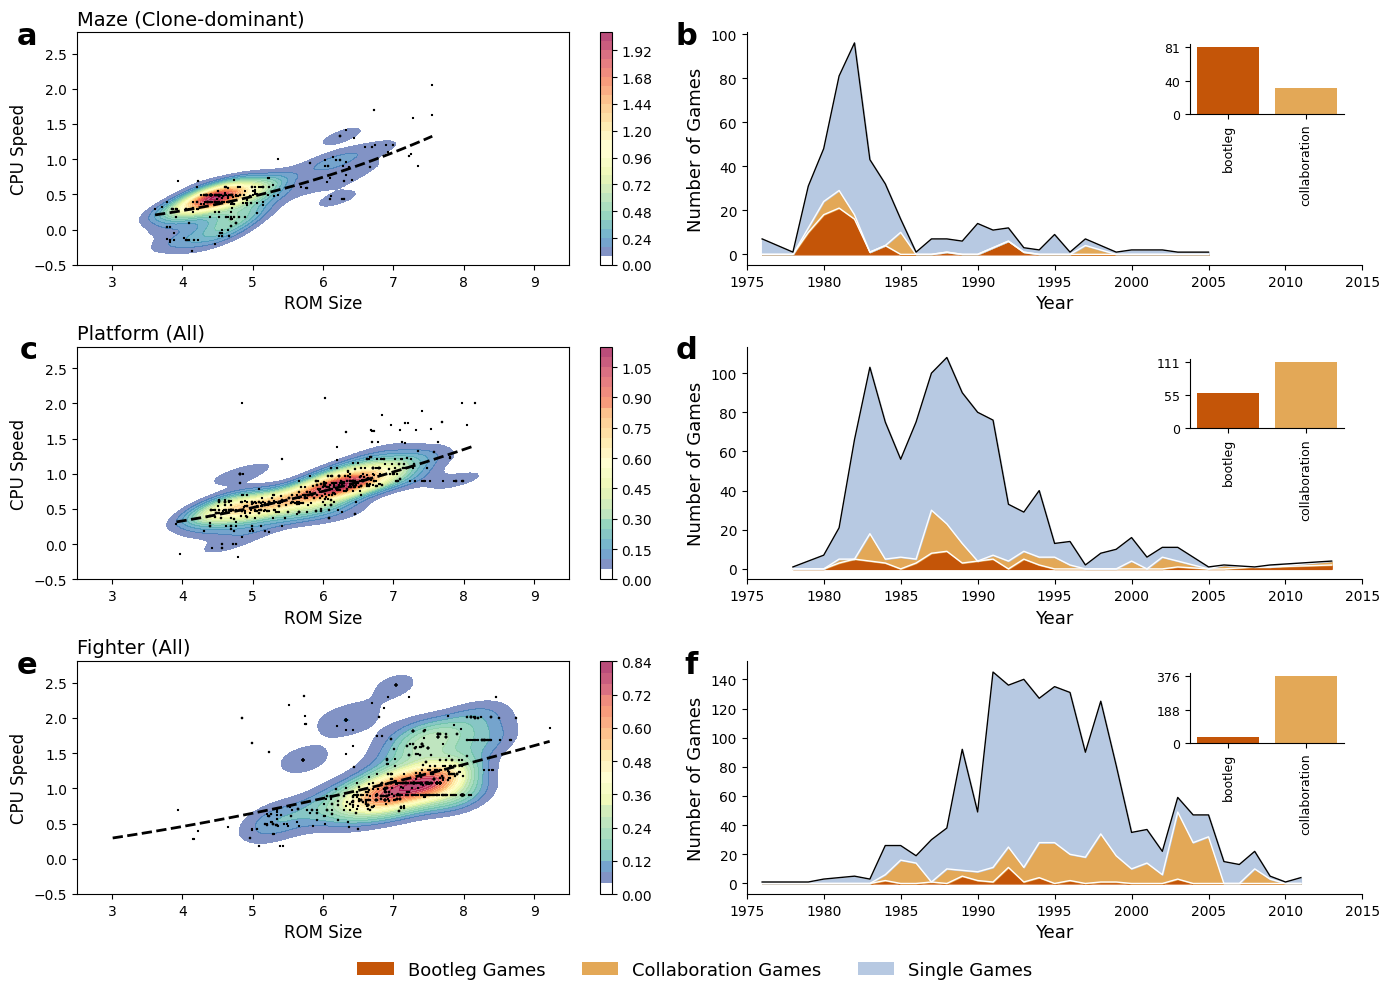

In [3]:
# ---- Function Definitions ---- #
def plot_morphospace(rom, speed, ax, title):
    """
    Plots the morphospace of ROM size vs. CPU speed with KDE and power-law fit.
    Computes confidence intervals for the power-law exponent.
    
    Parameters:
        rom (array-like): Log-transformed ROM sizes.
        speed (array-like): Log-transformed CPU speeds.
        title (str): Title for the plot.
    """
    # Compute KDE
    x_grid = np.linspace(2.5, 9.5, 100)
    y_grid = np.linspace(-0.5, 2.8, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    kde = gaussian_kde([rom, speed], bw_method=0.4)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Create plot
    contour = ax.contourf(X, Y, Z, levels=25, cmap=custom_cmap,vmin=0,alpha=0.7)
    ax.scatter(rom, speed, s=1, color="black", alpha=1,marker='+')
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    # cbar.set_label("Density")
    ax.set_title(title, fontsize=14, loc='left')
    # Set axis properties
    ax.set_xlim(2.5, 9.5)
    ax.set_ylim(-0.5, 2.8)
    ax.set_xlabel("ROM Size", fontsize=12)
    ax.set_ylabel("CPU Speed", fontsize=12)

    # Log-log regression
    valid_indices = (rom > 0) & (speed > 0)
    rom_filtered, speed_filtered = np.array(rom)[valid_indices], np.array(speed)[valid_indices]
    log_x, log_y = np.log(rom_filtered), np.log(speed_filtered)

    # Perform regression
    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    a = np.exp(intercept)
    b = slope

    # Compute 95% confidence interval
    n = len(log_x)
    dof = n - 2  # degrees of freedom
    t_val = t.ppf(0.975, dof)  # two-sided 95% CI
    ci = t_val * std_err
    lower_b = b - ci
    upper_b = b + ci

    # Plot power-law fit
    x_fit = np.linspace(min(rom_filtered), max(rom_filtered), 100)
    y_fit = a * x_fit**b

    ax.plot(x_fit, y_fit, color="black", linestyle="dashed", lw=2, 
             label=f"y = {a:.2f} * x$^{{{b:.2f} \pm {ci:.2f}}}$")

    # Output stats
    print(f"Fitted power-law: y = {a:.2f} * x^{b:.2f}")
    print(f"Exponent b: {b:.4f} ± {ci:.4f} (95% CI)")
    print(f"R²: {r_value**2:.4f}")


def plot_collab_yearly_inset(df_prod, subset, year, ax):
    """Plots collaboration trends with an inset histogram using stacked filled curves (bootleg on bottom)."""
    df_niche = df_prod[df_prod["category_id"].isin(subset)]
    print(f"Processed {len(df_niche)} rows ({len(df_niche) / len(df_prod):.2%})")

    # Collaboration types in desired stacking order: bootleg → collaboration → single
    collab_types = ["bootleg", "collaboration", "single"]
    colors = ["#C45508", "#E3A857", "xkcd:light blue grey"]

    # All years to include in the x-axis
    years = sorted(df_niche["year"].dropna().unique())

    # Prepare cumulative stacked data
    data = {collab: [] for collab in collab_types}
    for y in years:
        year_data = df_niche[df_niche["year"] == y]
        for collab in collab_types:
            count = (year_data["collaboration"] == collab).sum()
            data[collab].append(count)

    # Stack and fill
    bottom = np.zeros(len(years))
    for collab, color in zip(collab_types, colors):
        values = np.array(data[collab])
        ax.fill_between(years, bottom, bottom + values, color=color, alpha=1, label=f"{collab.capitalize()} Games")
        bottom += values
        ax.plot(years, bottom, color='white',lw=1)
    ax.plot(years, bottom, color='k',lw=1)
    ax.spines[['right', 'top']].set_visible(False)

    ax.set_xlim(1975, 2015)
    ax.set_xlabel("Year", fontsize=13)
    ax.set_ylabel("Number of Games", fontsize=13)
    # ax.legend(loc='upper left', fontsize=9)

    if year is not None:
        ax.axvline(year, color="gray", linestyle="--", linewidth=1)

    # Inset histogram of collaboration types (bootleg vs. collaboration only)
    inset_ax = ax.inset_axes([0.72, 0.65, 0.25, 0.3])
    collab_counts = df_niche["collaboration"].value_counts()
    # Only include 'bootleg' and 'collaboration'
    filtered = collab_counts.loc[["bootleg", "collaboration"]].reindex(["bootleg", "collaboration"]).fillna(0)
    bar_colors = [colors[collab_types.index(c)] for c in filtered.index]
    x = np.arange(len(filtered))
    inset_ax.bar(x, filtered.values, color=bar_colors)
    inset_ax.set_xticks(x)
    inset_ax.set_xticklabels(filtered.index, rotation=90, fontsize=9)
    # Add clean y-axis ticks (3 total)
    ymax = filtered.max()
    yticks = np.linspace(0, ymax, num=3, dtype=int)
    inset_ax.set_yticks(yticks)
    inset_ax.set_yticklabels(yticks, fontsize=9)
    inset_ax.spines[['right', 'top']].set_visible(False)

def find_collapsing_categories(df, main_cat):
    """Identifies subcategories within a main category where imitation ('bootleg') is more frequent than collaboration."""
    df_main_cat = df[df["main_category"] == main_cat]

    collapsing = {
        sub_cat
        for sub_cat, group in df_main_cat.groupby("sub_category")
        if group["collaboration"].value_counts().get("bootleg", 0) > group["collaboration"].value_counts().get("collaboration", 0)
    }

    collapsing_ids = list(set(df_main_cat[df_main_cat["sub_category"].isin(collapsing)]["category_id"]))
    return collapsing, collapsing_ids


def get_maincat_ids(df, main_cat):
    """Returns category IDs for a given main category."""
    return df[df["main_category"] == main_cat]["category_id"].tolist()


def get_trait_evo(df_prod):
    """Extracts and returns ROM size and CPU speed data."""
    rom, speed = [], []
    for _, row in df_prod.iterrows():
        rom.append(row["log_rom_size"])
        speed.append(row["log_clock_speed"])
    return np.array(rom), np.array(speed)


# ---- Data Processing ---- #

panels = []

# Maze category with "collapsing" subcategories. This is actually a clone-dominant category.
maze_collapsing = find_collapsing_categories(df_prod, "Maze")[1]
print ("Collapsing subcategories in Maze:")
for cat in maze_collapsing:
    print (cat, category_map[cat])
df_maze = df_prod[df_prod["category_id"].isin(maze_collapsing)]
panels.append(("Maze (Clone-dominant)", maze_collapsing, *get_trait_evo(df_maze)))

# Platform category
platform_ids = get_maincat_ids(df_prod, "Platform")
df_platform = df_prod[df_prod["category_id"].isin(platform_ids)]
panels.append(("Platform (All)", platform_ids, *get_trait_evo(df_platform)))

# Fighter category
fighter_ids = get_maincat_ids(df_prod, "Fighter")
df_fighter = df_prod[df_prod["category_id"].isin(fighter_ids)]
panels.append(("Fighter (All)", fighter_ids, *get_trait_evo(df_fighter)))

# ---- Plotting ---- #

fig, ax = plt.subplots(3, 2, figsize=(14, 10))

for i, (title, subset_id, rom, speed) in enumerate(panels):
    print (title, subset_id)
    print ("------")
    plot_collab_yearly_inset(df_prod, subset_id, None, ax[i, 1])
    plot_morphospace(rom, speed, ax[i, 0], title)


# Add subplot labels: a, b, c, d, e, f
labels = list("abcdef")
for idx, axis in enumerate(ax.flat):
    axis.text(-0.08, 1.05, labels[idx], transform=axis.transAxes,
              fontsize=22, fontweight='bold', va='top', ha='right')



plt.tight_layout()

# Shared horizontal legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#C45508", label="Bootleg Games"),
    Patch(facecolor="#E3A857", label="Collaboration Games"),
    Patch(facecolor="xkcd:light blue grey", label="Single Games"),
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=13, frameon=False)
plt.subplots_adjust(bottom=0.1)  # Make space for legend


plt.savefig("fig4.svg", dpi=300, bbox_inches='tight')

plt.show()
